We use resnet to extract features. Instead of using features from the last layer, we use features from an intermediate layer. This gives us better performance in anomaly detection tasks. Here we make memory banks from the patches instead of the whole image, and then we use KNN to classify the patches as having anomaly or not. No model training required. auc of 0.98.

In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

In [2]:
base_path = Path("/kaggle/input/mvtec-ad/carpet")
train_path = base_path / "train"
test_path = base_path / "test"

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor()
])

In [10]:
class resnet_feature_extractor(torch.nn.Module):
    def __init__(self):
        """This class extracts the feature maps from a pretrained Resnet model."""
        super(resnet_feature_extractor, self).__init__()
        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False

        

        # Hook to extract feature maps
        def hook(module, input, output) -> None:
            """This hook saves the extracted feature map on self.featured."""
            self.features.append(output)

        self.model.layer2[-1].register_forward_hook(hook)            
        self.model.layer3[-1].register_forward_hook(hook) 

    def forward(self, input):

        self.features = []
        with torch.no_grad():
            _ = self.model(input)

        self.avg = torch.nn.AvgPool2d(3, stride=1)
        fmap_size = self.features[0].shape[-2]         # Feature map sizes h, w
        self.resize = torch.nn.AdaptiveAvgPool2d(fmap_size)

        resized_maps = [self.resize(self.avg(fmap)) for fmap in self.features]
        patch = torch.cat(resized_maps, 1)            # Merge the resized feature maps
        patch = patch.reshape(patch.shape[1], -1).T   # create a column tensor

        return patch

In [11]:
sample = test_path / "color" / "000.png"
sample_image = Image.open(sample)
image_tensor = transform(sample_image).unsqueeze(0).cuda()

backbone = resnet_feature_extractor().cuda()
feature = backbone(image_tensor)

print(backbone.features[0].shape)
print(backbone.features[1].shape)
print(feature.shape)

torch.Size([1, 512, 28, 31])
torch.Size([1, 1024, 14, 16])
torch.Size([784, 1536])


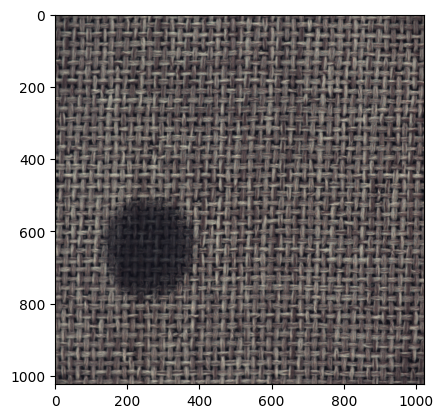

In [12]:
plt.imshow(sample_image)

In [21]:
for i, fmap in enumerate(backbone.features):
    print(f"Feature Map {i}: shape = {fmap.shape}")

print("Final patch shape:", features.shape)


Feature Map 0: shape = torch.Size([1, 512, 28, 31])
Feature Map 1: shape = torch.Size([1, 1024, 14, 16])
Final patch shape: torch.Size([784, 1536])


There aer 784 patch vectors, each with 1536 features

In [13]:

memory_bank =[]

folder_path = train_path/ "good"

for pth in tqdm(folder_path.iterdir(),leave=False):

    with torch.no_grad():
        data = transform(Image.open(pth)).cuda().unsqueeze(0)
        features = backbone(data)
        memory_bank.append(features.cpu().detach())

memory_bank = torch.cat(memory_bank,dim=0).cuda()

0it [00:00, ?it/s]

In [16]:
print(len(memory_bank))
print(memory_bank[0].shape)

219520
torch.Size([1536])


In [22]:
print(784*280)

219520


Using only 10% of hte patches 

In [17]:
selected_indices = np.random.choice(len(memory_bank), size=len(memory_bank)//10, replace=False)
memory_bank = memory_bank[selected_indices]

In [23]:
len(memory_bank)

21952

In [18]:
y_score=[]
folder_path = train_path / "good"

for pth in tqdm(folder_path.iterdir(),leave=False):
    data = transform(Image.open(pth)).cuda().unsqueeze(0)
    with torch.no_grad():
        features = backbone(data)
    distances = torch.cdist(features, memory_bank, p=2.0)
    dist_score, dist_score_idxs = torch.min(distances, dim=1) 
    s_star = torch.max(dist_score)
    segm_map = dist_score.view(1, 1, 28, 28) 

    y_score.append(s_star.cpu().numpy())

0it [00:00, ?it/s]

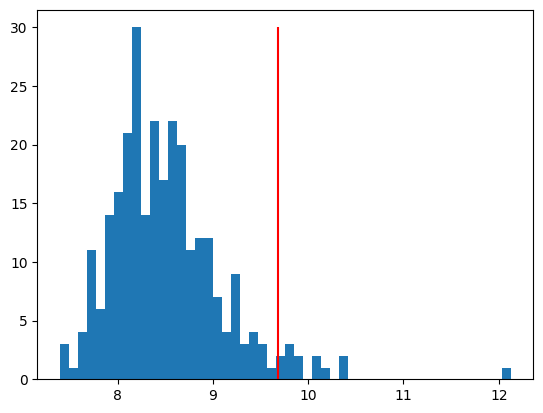

In [19]:
best_threshold = np.mean(y_score) + 2 * np.std(y_score)

plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

In [25]:
y_score = []
y_true=[]

for classes in ['color','good','cut','hole','metal_contamination','thread']:
    folder_path = Path(f"{test_path}/{classes}")

    for pth in tqdm(folder_path.iterdir(),leave=False):

        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0)
            features = backbone(test_image)

        distances = torch.cdist(features, memory_bank, p=2.0)
        dist_score, dist_score_idxs = torch.min(distances, dim=1) 
        s_star = torch.max(dist_score)
        segm_map = dist_score.view(1, 1, 28, 28) 

        y_score.append(s_star.cpu().numpy())
        y_true.append(0 if class_label == 'good' else 1)
           

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

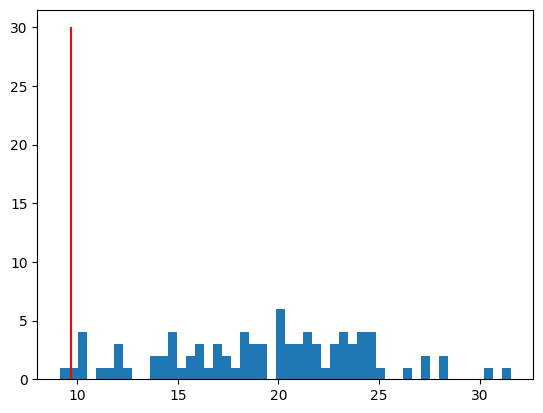

In [26]:
y_score_nok = [score  for score,true in zip(y_score,y_true) if true==1]
plt.hist(y_score_nok,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

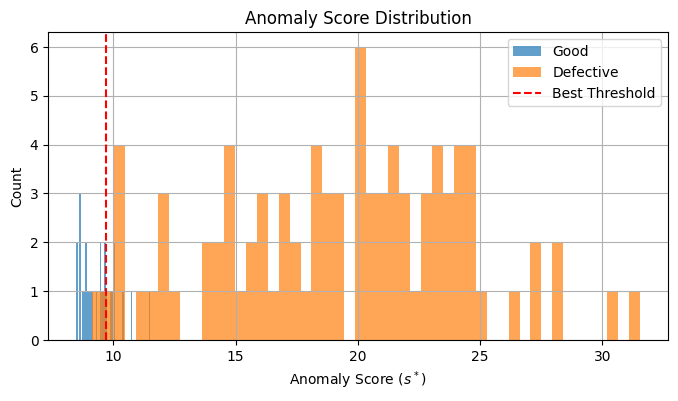

In [27]:
import matplotlib.pyplot as plt

y_score_good = [score for score, label in zip(y_score, y_true) if label == 0]
y_score_nok = [score for score, label in zip(y_score, y_true) if label == 1]

plt.figure(figsize=(8, 4))
plt.hist(y_score_good, bins=50, alpha=0.7, label='Good')
plt.hist(y_score_nok, bins=50, alpha=0.7, label='Defective')
plt.axvline(x=best_threshold, color='red', linestyle='--', label='Best Threshold')
plt.xlabel("Anomaly Score ($s^*$)")
plt.ylabel("Count")
plt.title("Anomaly Score Distribution")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
from collections import defaultdict

scores_per_class = defaultdict(list)

for classes in ['color', 'good', 'cut', 'hole', 'metal_contamination', 'thread']:
    folder_path = Path(f"{test_path}/{classes}")
    for pth in folder_path.iterdir():
        class_label = pth.parts[-2]

        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0)
            features = backbone(test_image)
            distances = torch.cdist(features, memory_bank)
            dist_score, _ = torch.min(distances, dim=1)
            s_star = torch.max(dist_score)

        scores_per_class[class_label].append(s_star.item())


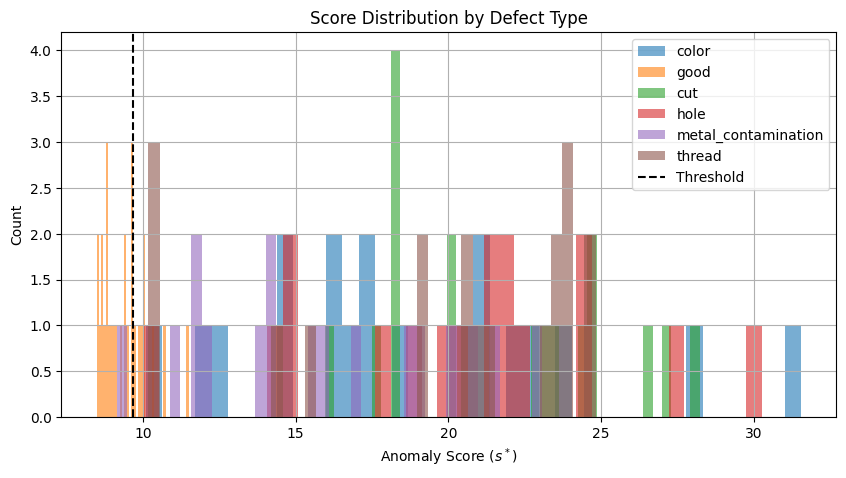

In [29]:
plt.figure(figsize=(10, 5))
for cls, scores in scores_per_class.items():
    plt.hist(scores, bins=40, alpha=0.6, label=cls)

plt.axvline(x=best_threshold, color='black', linestyle='--', label='Threshold')
plt.xlabel("Anomaly Score ($s^*$)")
plt.ylabel("Count")
plt.title("Score Distribution by Defect Type")
plt.legend()
plt.grid(True)
plt.show()


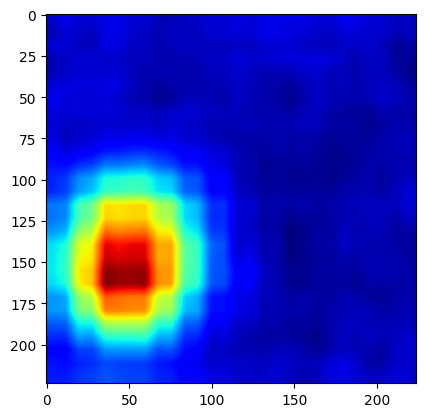

In [30]:
test_image = transform(Image.open(test_path/"color"/"000.png")).cuda().unsqueeze(0)
features = backbone(test_image)

distances = torch.cdist(features, memory_bank, p=2.0)
dist_score, dist_score_idxs = torch.min(distances, dim=1) 
s_star = torch.max(dist_score)
segm_map = dist_score.view(1, 1, 28, 28)

segm_map = torch.nn.functional.interpolate(     # Upscale by bi-linaer interpolation to match the original input resolution
                segm_map,
                size=(224, 224),
                mode='bilinear'
            )

plt.imshow(segm_map.cpu().squeeze(), cmap='jet')

AUC-ROC Score: 0.9871589085072231


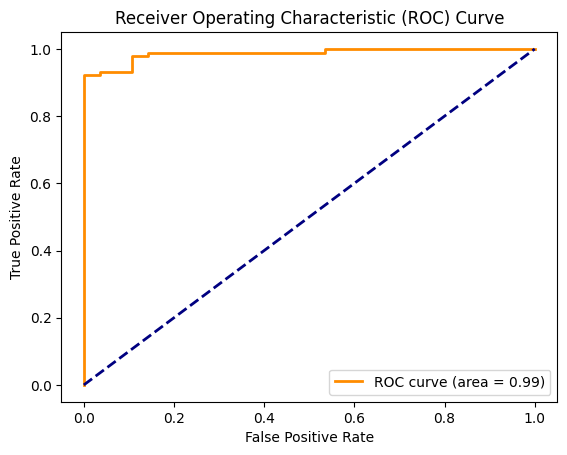

best_threshold = 10.027227401733398
f1 score: 0.9723756906077348


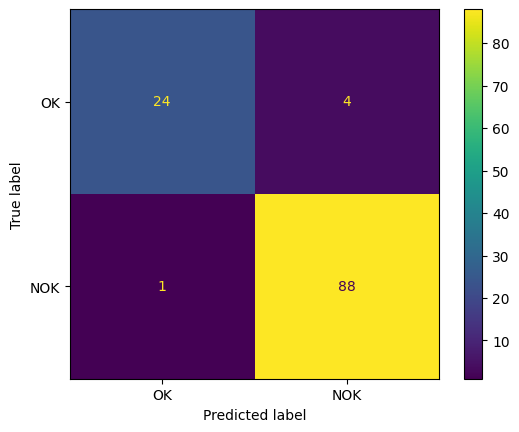

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score


auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')
print(f"f1 score: {np.max(f1_scores)}")

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()

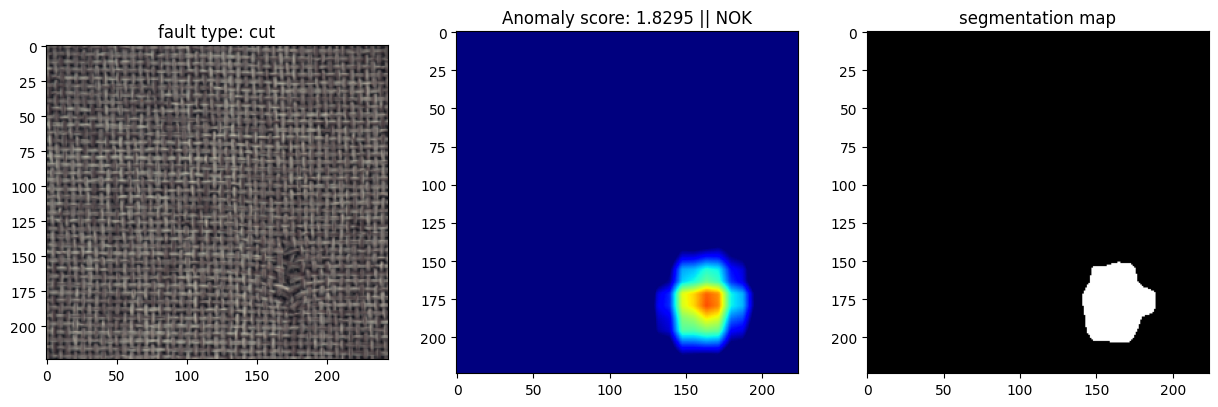

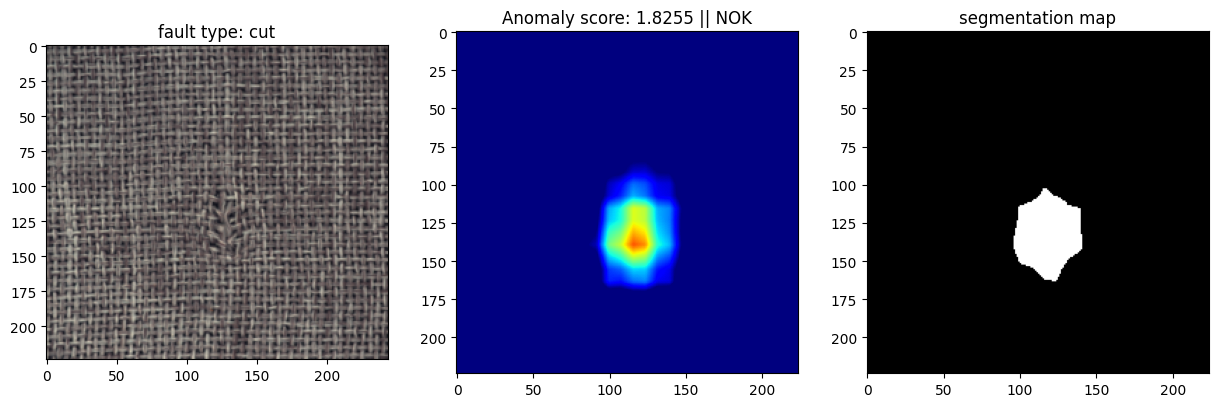

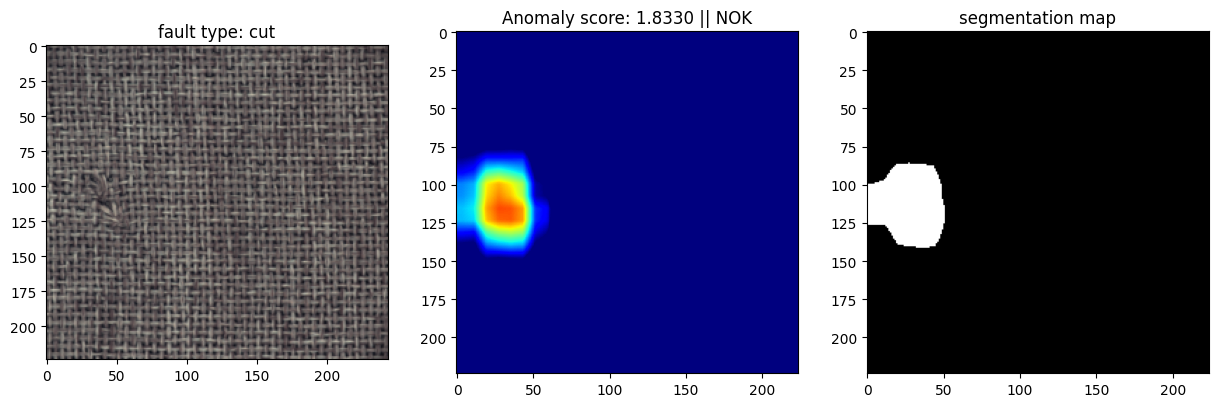

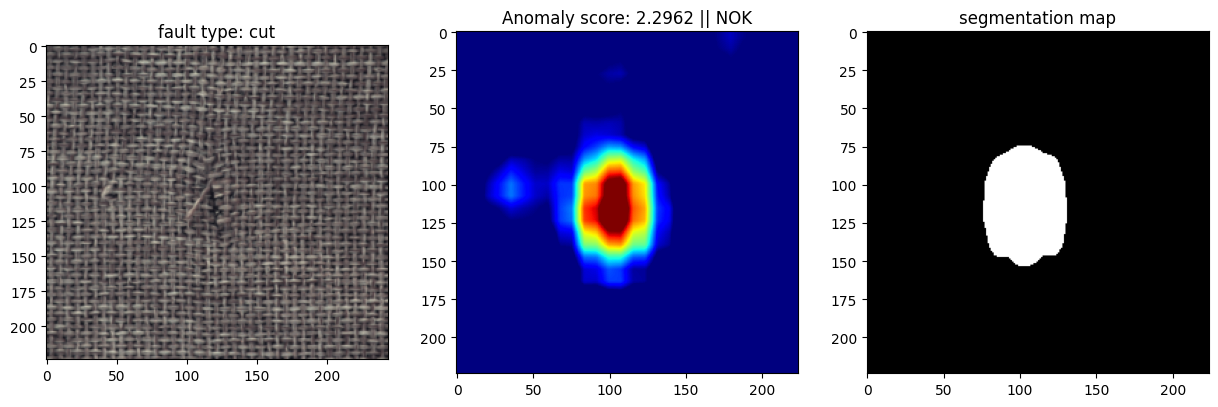

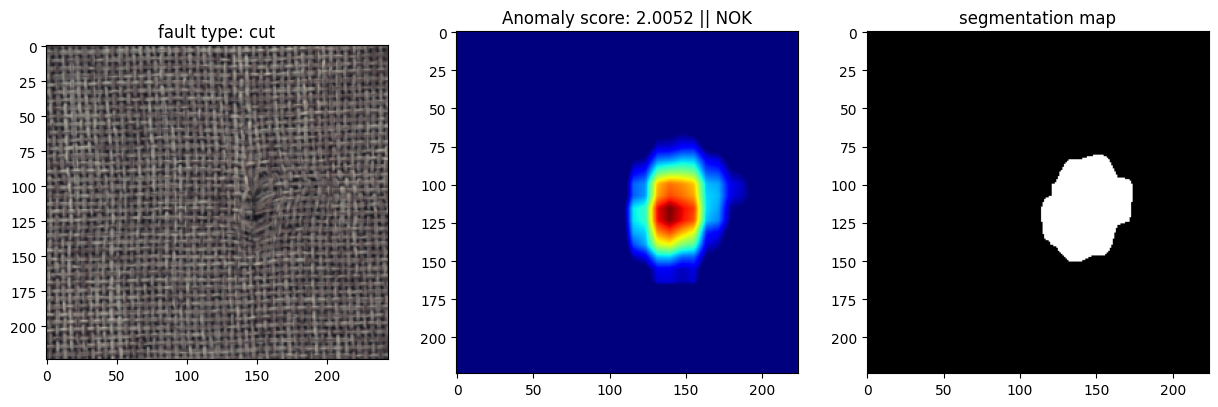

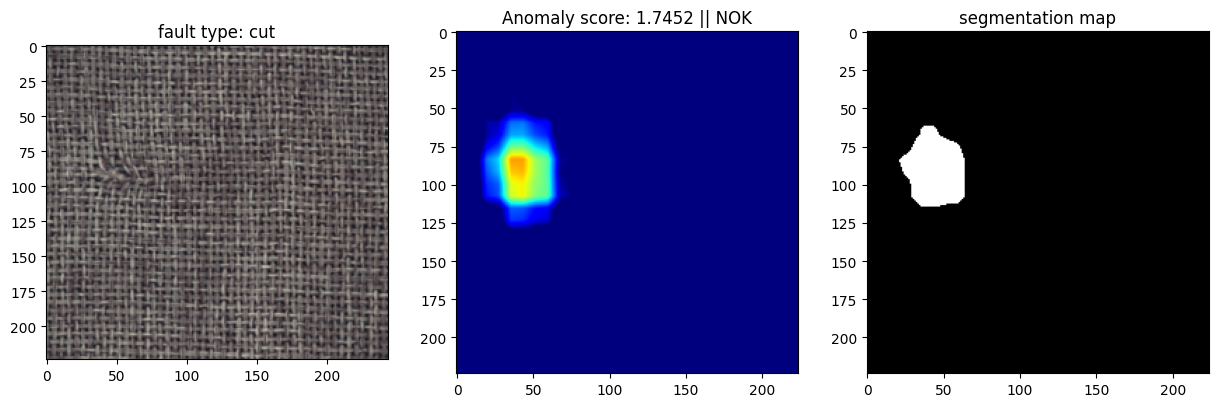

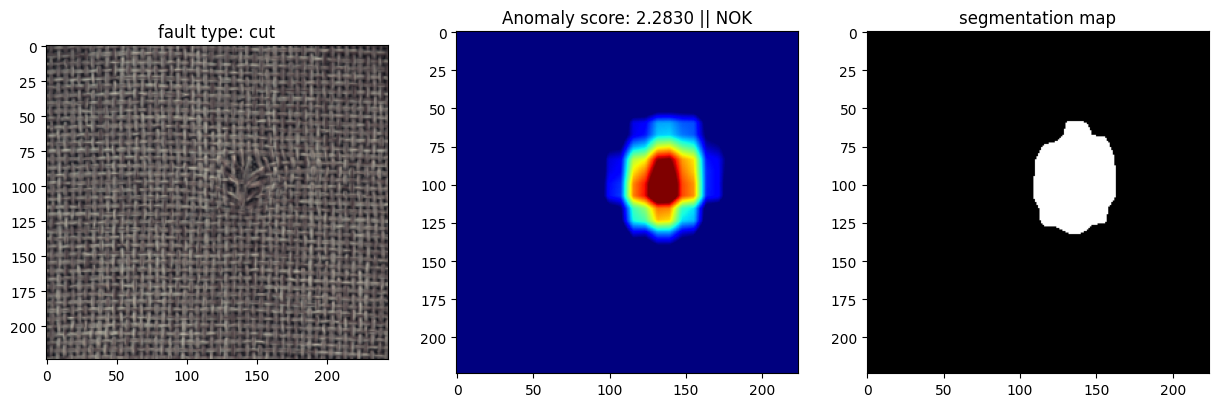

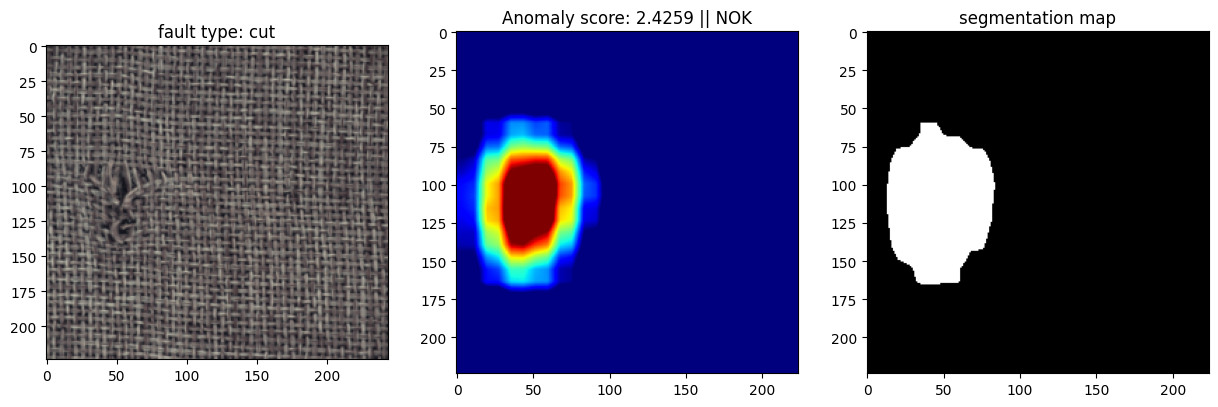

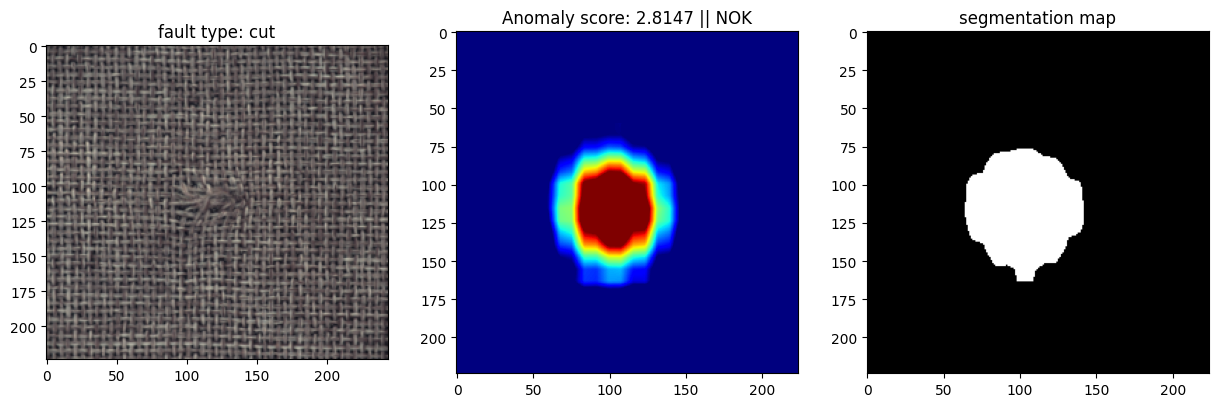

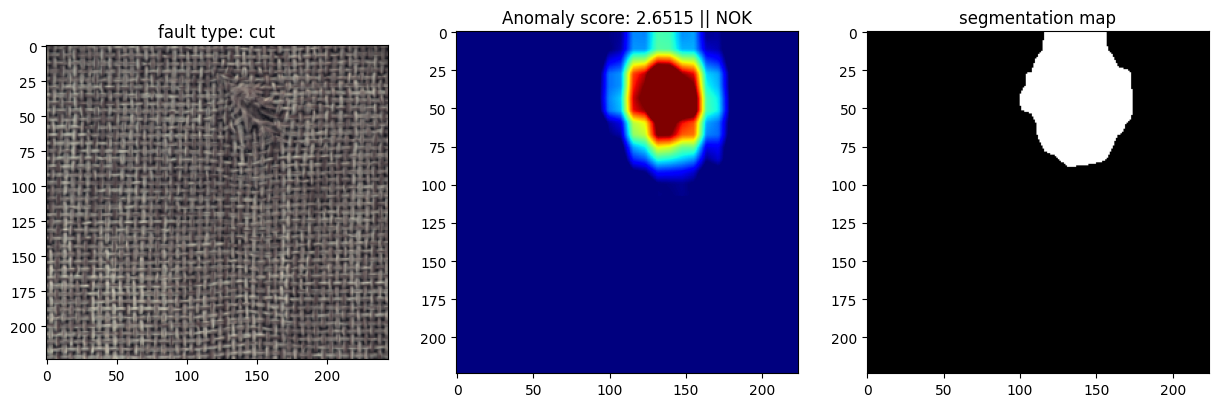

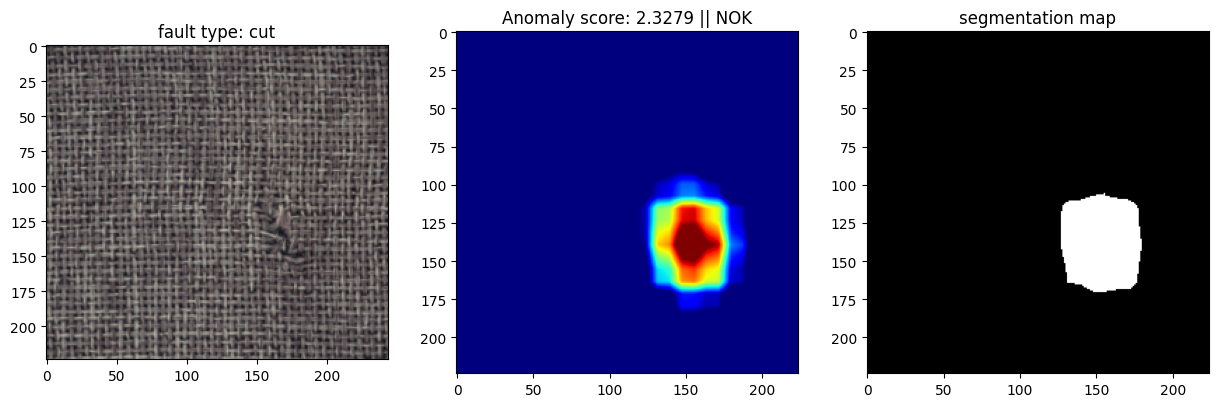

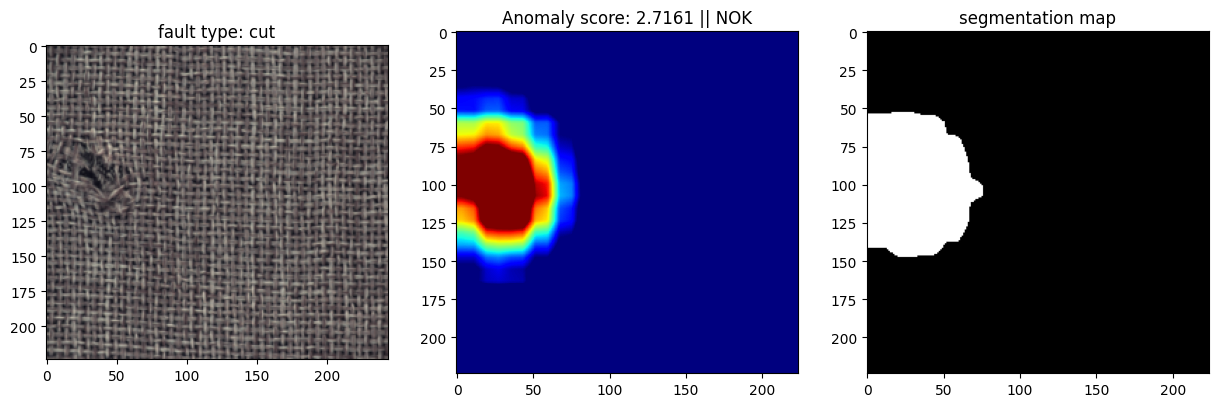

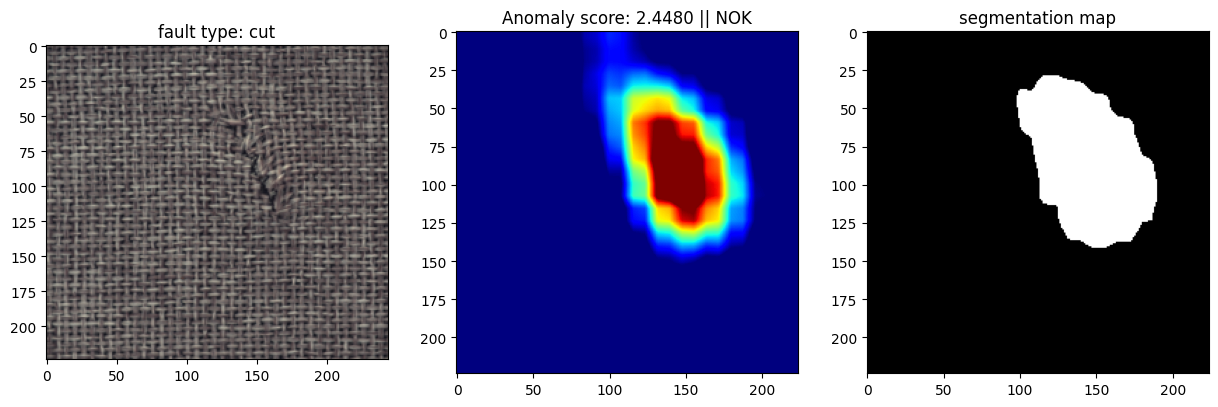

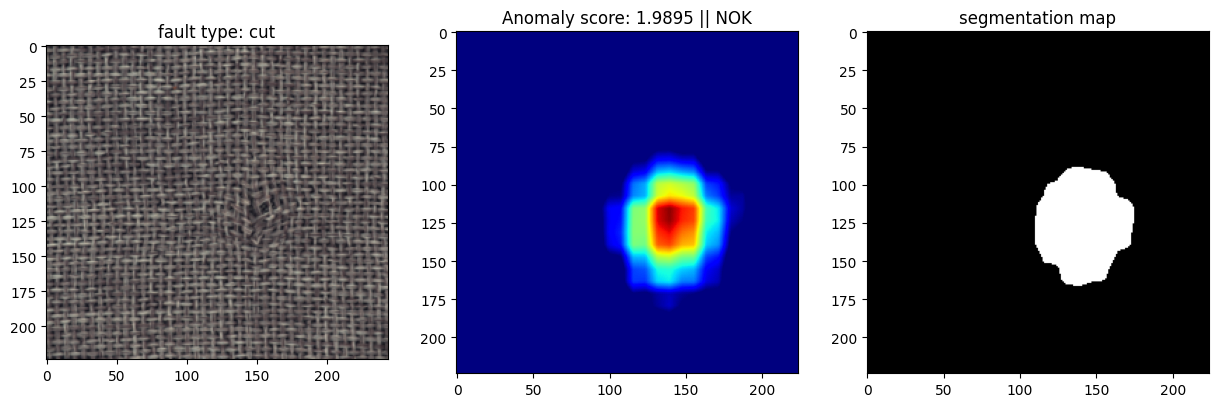

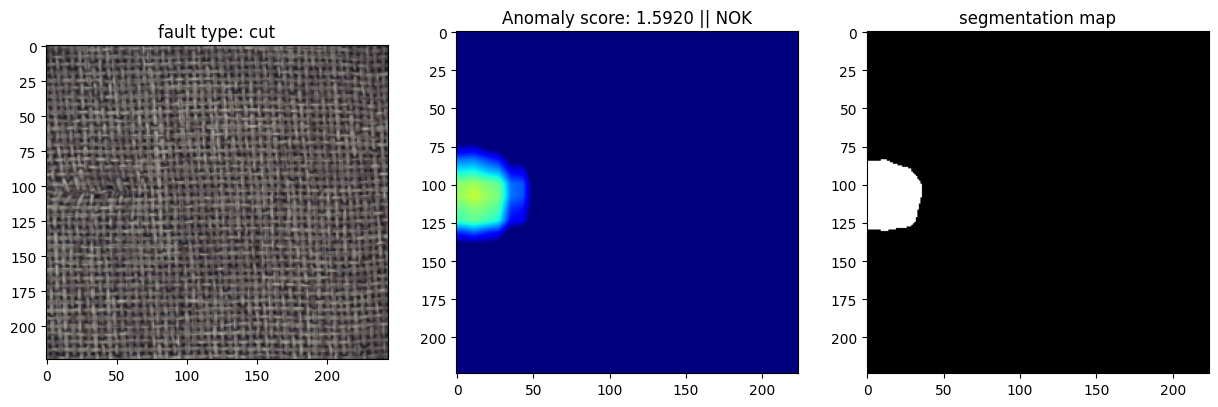

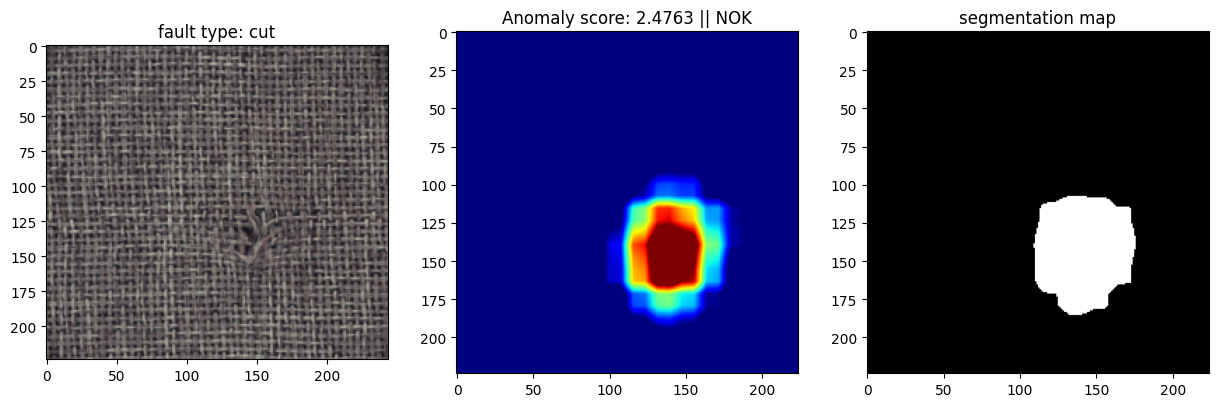

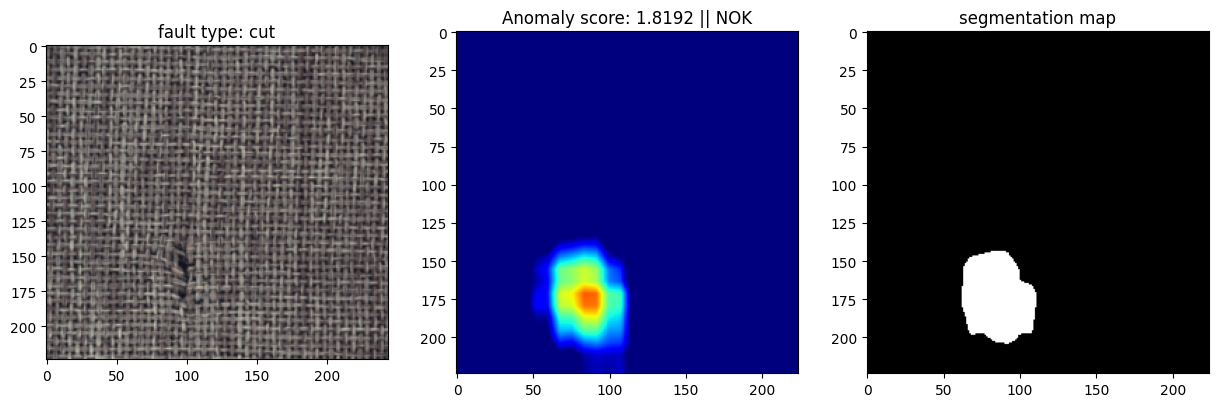

In [32]:
import cv2, time
from IPython.display import clear_output

backbone.eval()

for path in test_path.glob('*/*.png'): 

    fault_type = path.parts[-2]

    if fault_type in ['cut']:
            
        test_image = transform(Image.open(path)).cuda().unsqueeze(0)
        
        with torch.no_grad():
            features = backbone(test_image)
        # Forward pass
        distances = torch.cdist(features, memory_bank, p=2.0)
        dist_score, dist_score_idxs = torch.min(distances, dim=1) 
        s_star = torch.max(dist_score)
        segm_map = dist_score.view(1, 1, 28, 28) 
        segm_map = torch.nn.functional.interpolate(     # Upscale by bi-linaer interpolation to match the original input resolution
                    segm_map,
                    size=(224, 224),
                    mode='bilinear'
                ).cpu().squeeze().numpy()
        
        y_score_image = s_star.cpu().numpy()
        
        y_pred_image = 1*(y_score_image >= best_threshold)
        class_label = ['OK','NOK']


        plt.figure(figsize=(15,5))

        plt.subplot(1,3,1)
        plt.imshow(test_image.squeeze().permute(1,2,0).cpu().numpy())
        plt.title(f'fault type: {fault_type}')

        plt.subplot(1,3,2)
        heat_map = segm_map
        plt.imshow(heat_map, cmap='jet',vmin=best_threshold, vmax=best_threshold*2) 
        plt.title(f'Anomaly score: {y_score_image / best_threshold:0.4f} || {class_label[y_pred_image]}')

        plt.subplot(1,3,3)
        plt.imshow((heat_map > best_threshold*1.25), cmap='gray')
        plt.title(f'segmentation map')
        
        plt.show()

        # time.sleep(0.05)
        # clear_output(wait=True)

In [36]:
torch.save(memory_bank, "memory_bank.pt")


- But now if I try with a different carpet of a different colour etc, it would not generalize, it would consider it an anamoly
- Can try with multiple different memory banks